## Introduction
----
Given your experience with batch least squares (where all measurements are processed at once), you now decide convert your batch solution to a recursive one for added flexibility. Recall that you have the following data:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

This time, you intend to fit a linear model that includes an offset term, $V = RI + b$. If Ohm's law ($V = RI$) holds, you expect this offset to be very near to zero.

To use the recursive least squares formulation, you must have a prior estimate of the resistance and its associated uncertainty (otherwise, you won't know how to weigh the information you receive from a new measurement). You choose to set the initial parameters under the assumption that your prior estimate of the resistance, $R = 4$, is not very good. Also, since you are fairly sure that Ohm's law ($V = RI$) does, in fact, hold, you feel that it is safe to assume with high confidence that the offset term $b$ is close to zero. After some thought, you choose to intialize the recursive estimator as follows:

$$\hat{R} \sim \mathcal{N}(4, 9.0),~~\hat{b} \sim \mathcal{N}(0, 0.2)$$

Your initial guess is that $\hat{R}$ follows a Gaussian or normal distribution (recall that you do not know the exact value of $R$, so it must be considered as a random variable) with a mean of $4~\Omega$ and a standard deviation of $3~ \Omega$ (i.e., a variance of $9~\Omega^{2}$). Similarly, your intial guess is that $\hat{b}$ should also follow a normal distribution with a mean of $0~V$ and a variance of $0.2~V^{2}$.

With the data again in hand, your goals are to: 
1. Fit a line to the data that includes an offset term (i.e., determine the parameters $R$ and $b$ for $y = Rx + b$) by using the method of recursive least squares. 
2. Reflect on the differences between the batch and recursive least squares solutions.

You may assume that the current values are known exactly, and that the voltage measurements are corrupted by additive, independent and identitically distributed zero-mean Gaussian noise with a standard deviation of $0.15~V$ (i.e., a variance of $0.0225 ~ V^2$). You may also assume that your initial estimates for $\hat{R}$ and $\hat{b}$ are uncorelated (i.e., the off-diagonal elements of the $2 \times 2$ covariance matrix are zero). 

## Getting Started
----
As before, the first step is to import the neccesary Python modules and load the current values and voltage measurements into NumPy arrays:

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

I = np.array([[0.2, 0.3, 0.4, 0.5, 0.6]]).T
V = np.array([[1.23, 1.38, 2.06, 2.47, 3.17]]).T

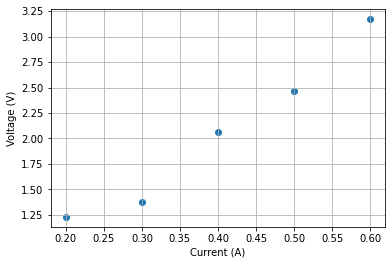

In [2]:
plt.scatter(I, V)
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()

## Estimating the Slope and Offset Parameters
----
### Batch Estimator
Before implementing the recursive least squares estimator, let's examine the parameter estimates given by the batch least squares method used in the previous assignment. This time, you will be fitting a model which contains an offset $y = Rx + b$. This result can be used later for comparison.

The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:
4.970000000000006
0.07399999999999807


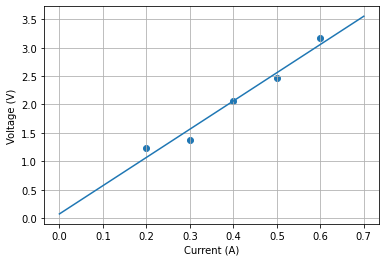

In [3]:
## Batch Solution

H = np.ones((5, 2))
H[:, 0] = I.ravel()
x_ls = inv(H.T.dot(H)).dot(H.T.dot(V))
print('The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:')
print(x_ls[0, 0])
print(x_ls[1, 0])

# Plot line.
I_line = np.arange(0, 0.8, 0.1).reshape(8, 1)
V_line = x_ls[0]*I_line + x_ls[1]

plt.scatter(I, V)
plt.plot(I_line, V_line)
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()

As expected, the offset parameter $\hat{b}$ is near zero, while $\hat{R}$ closely approximates the true resistance value of $R = 5~\Omega$.

### Recursive Estimator
Now let's try to implement the least squares method recursively! Recall the steps described in Module 1, Lesson 2 - "Recursive Least Squares": 

**Initialize the parameter and covariance estimates**:

----
$$
\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right],\quad \mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]
$$

**For every measurement k**:

----
  * Calculate the gain term: $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Update the parameter estimate: $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Update the covariance estimate: $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$
  
In this case, the initial parameter vector $\hat{\mathbf{x}}_0$ should contain $\hat{R}$ and $\hat{b}$. 

In [9]:
## Recursive Solution

# Initialize the 2x1 parameter vector x (i.e., x_0).
# x_k = ...
x_k = np.array([4.0, 0.0]).reshape(2, 1)

#Initialize the 2x2 covaraince matrix (i.e. P_0). Off-diangonal elements should be zero.
# P_k = ...
P_k = np.array([[9.0, 0.0],
                [0.0, 0.2]]).reshape(2, 2)

# Our voltage measurement variance (denoted by R, don't confuse with resistance).
R_k = np.array([[0.0225]])

# Pre allocate space to save our estimates at every step.
num_meas = I.shape[0]
x_hist = np.zeros((num_meas + 1, 2))
P_hist = np.zeros((num_meas + 1, 2, 2))

x_hist[0] = x_k.reshape(2)
P_hist[0] = P_k.reshape(2, 2)

# Iterate over all the available measurements.
for k in range(num_meas):
    # Construct H_k (Jacobian).
    # H_k = ...
    I = I.reshape(I.shape[0])
    H_k = np.array([[I[k], 1.0]])

    # Construct K_k (gain matrix).
    # K_k = ...
    K_k = P_k @ H_k.T @ np.linalg.inv(H_k @ P_k @ H_k.T + R_k)
                    
    # Update our estimate.
    # x_k = ...
    x_k = x_k + K_k @ (V[k] - H_k @ x_k)
 
    # Update our uncertainty (covariance)
    # P_k = ...    
    P_k = (np.eye(2) - K_k @ H_k) @ P_k

    # Keep track of our history.
    P_hist[k + 1] = P_k.reshape(2, 2)
    x_hist[k + 1] = x_k.reshape(2)
    
print('The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:')
print(x_k[0, 0])
print(x_k[1, 0])

The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:
4.976925034352892
0.06966257824825756


## Plotting the Results
----
Let's plot out the solution at each step. Does the resistance value converge towards the batch least squares solution?

In [ ]:
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1).reshape(8, 1)

for k in range(num_meas):
    V_line = x_hist[k, 0]*I_line + x_hist[k, 1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))

plt.legend()
plt.show()

The resistance estimate $\hat{R}$ should approach the true resistance value of $R = 5~\Omega$ very closely (i.e., to within a few hundredths of ohms). As expected, the offset term $\hat{b}$ should be small as well (less than 0.1 ohms). Try modifying the initialization (e.g., the intial uncertainty of the prior guess) - can you get a better final esimate?